# House pricing on the basis of square footage and realtor assesment

## Problem formulation

Authors:
 - Nicolas Duc
 - Piotr Kula

#### Goal of this project 
The goal of this project is analysis of the market prices of houses on the basis of the square footage and the realtor's assesment.

The proposed model can be then used to asses if the given price is a good deal and to check whether the house price is comparable to the market standard.

### Data

The data was obtained from kaggle.com.

Dataset contains different types of data such as numner of bedrooms, zipcode, year it was built, we only use the square footage of the living space and the grade that the realtor has given to the house.

The dataset itself contains over 21000 records, however for the purpose of the project we sample 100 records that will later be used.

In [158]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import random as rd
# print(len(pd.read_csv('kc_house_data.csv')))
df = (pd.read_csv("house_data_sampled.csv").sample(100)).reset_index()

The sqft living metrage is centered and standardized for the purpose of the further analysis.

In [159]:

mean_sqft_living = (df['sqft_living']).mean()
sd_sqft_living = (df['sqft_living']).std()
sqft_living_centered = ((df['sqft_living']).copy())
sqft_living_standardized = ((df['sqft_living']).copy())

grade_standardized = (df['grade']).copy()
for i in range(len(df['sqft_living'])):
    sqft_living_centered[i] = ((df['sqft_living'])[i]-mean_sqft_living)
    sqft_living_standardized[i] = ((df['sqft_living'])[i]-mean_sqft_living)/sd_sqft_living


In [160]:
grade_moved = ((df['grade']).copy())
for i in range(len(grade_moved)):
    grade_moved[i] = int(grade_moved[i]-6)
print(f"MIN: {grade_moved.min()} MAX: {grade_moved.max()}")

MIN: 0 MAX: 5


## Model 1 - one parameter

Model 1 is basing the predictions of the price of house on the basis of the area of the living space of the house.

### Prior

The parameters for the prior have been selected on the basis of a reseach on the Internet for the mean price and price for the square feet of the house in United States for year 2014 in similar location. 

In [161]:
sqft_linspace = np.linspace(sqft_living_centered.min(),sqft_living_centered.max())
data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace}

In [162]:
one_param_ppc_a = CmdStanModel(stan_file='CommandFiles/one_param_ppc.stan')
one_param_ppc_a_simulated = one_param_ppc_a.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


Prior predictive check. The peak in all the parameters in 0 is due to constraint given in the stan file, such as alpha and beta cannot be lower than 0.

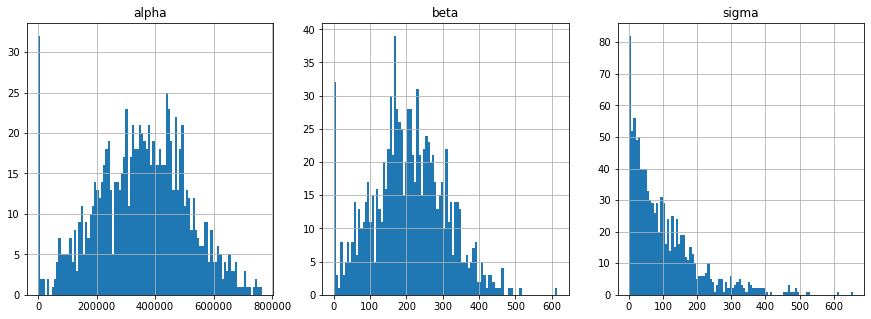

,mean,sd,hdi_3%,hdi_97%
alpha,352321.48,158063.89,0.0,592987.00
beta,206.29,101.33,0.0,364.79
sigma,100.88,99.54,0.0,295.96


In [163]:
alpha_sim = one_param_ppc_a_simulated.stan_variable('alpha')
beta_sim = one_param_ppc_a_simulated.stan_variable('beta')
sigma_sim = one_param_ppc_a_simulated.stan_variable('sigma')
price_sim = one_param_ppc_a_simulated.stan_variable('price')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim, bins=100);
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sim, bins=100);
axs[1].grid()
axs[1].set_title('beta')
axs[2].hist(sigma_sim, bins=100);
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(one_param_ppc_a_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

Prior predictive check for measurements. We can see however that for some prices are negative, but most of the generated measuremets are in the expected range.

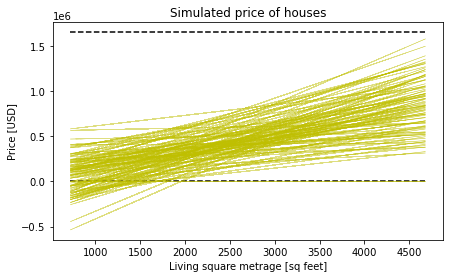

In [164]:
alpha_sim=one_param_ppc_a_simulated.stan_variable('alpha')
beta_sim=one_param_ppc_a_simulated.stan_variable('beta')

fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines(
    [0,(df['price']).max()],
    xmin=df['sqft_living'].min(),
    xmax=df['sqft_living'].max(),
    linestyle='--',color='black'
    )
for i in range(100):
    axes.plot(
        df['sqft_living'],
        alpha_sim[i]+beta_sim[i]*sqft_living_centered,
        color = 'y', alpha=0.5, linewidth=0.5
        )
plt.title("Simulated price of houses");
plt.xlabel("Living square metrage [sq feet]");
plt.ylabel("Price [USD]");

### Posterior

In [165]:
data = {'N': len(sqft_living_centered),
        'sqft': sqft_living_centered,
        'price': df['price']}
one_param = CmdStanModel(stan_file='CommandFiles/one_param.stan')
one_param_simulated = one_param.sample(data=data, seed=21370204)

INFO:cmdstanpy:compiling stan file C:\STUFF\8th_semester\DA_project\CommandFiles\one_param.stan to exe file C:\STUFF\8th_semester\DA_project\CommandFiles\one_param.exe
INFO:cmdstanpy:compiled model executable: C:\STUFF\8th_semester\DA_project\CommandFiles\one_param.exe
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


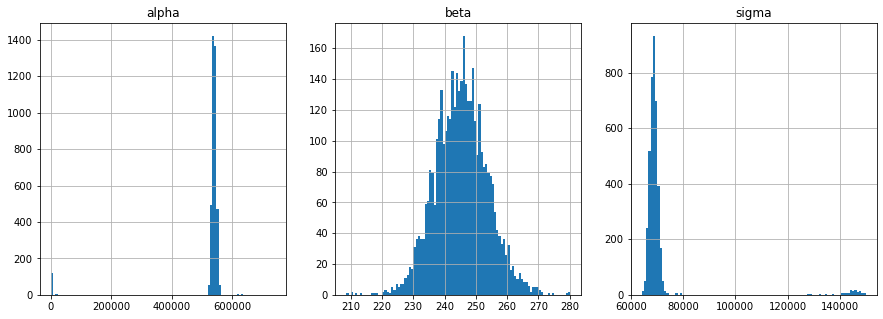

,mean,sd,hdi_3%,hdi_97%
alpha,525101.78,93812.62,527038.00,556683.00
beta,245.33,8.33,230.29,260.83
sigma,71140.14,13046.97,65896.50,72076.30


In [179]:
alpha_sim = one_param_simulated.stan_variable('alpha')
beta_sim = one_param_simulated.stan_variable('beta')
sigma_sim = one_param_simulated.stan_variable('sigma')
price_sim = one_param_simulated.stan_variable('price_sim')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim, bins=100);
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sim, bins=100);
axs[1].grid()
axs[1].set_title('beta')
axs[2].hist(sigma_sim, bins=100);
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(one_param_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

Here we can see that the majority of tha parameter alpha is concentrated around 500k. The beta is slightly diffused with most of the parameter concentrated around 245.

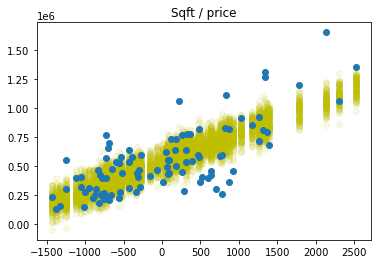

In [167]:
prices_sim=one_param_simulated.stan_variable('price_sim')

# for i in range(0,len(df['sqft_living'])):
for i in range(100):
    plt.scatter(sqft_living_centered, prices_sim[i], color="y", alpha=0.1)

plt.scatter(sqft_living_centered, df["price"])

plt.title("Sqft / price")
plt.show()

We can see that the generated samples correspond to the majority of the data. There are however some outliers.

## Model 2 - discrete grade

### Prior

In this prior we added another parameter to improve the predictions - grade of the house, given by the realtor.

In [230]:
sqft_linspace = np.linspace(sqft_living_standardized.min(),sqft_living_standardized.max(),100)
grade_in = grade_moved.sample(100).sort_values()

data = {'N': len(sqft_linspace),
        'sqft': sqft_living_centered,
        'grade': grade_in}
two_params_discrete_ppc = CmdStanModel(stan_file='CommandFiles/two_param_discrete_ppc.stan')
two_params_discrete_ppc_simulated = two_params_discrete_ppc.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:compiling stan file C:\STUFF\8th_semester\DA_project\CommandFiles\two_param_discrete_ppc.stan to exe file C:\STUFF\8th_semester\DA_project\CommandFiles\two_param_discrete_ppc.exe
INFO:cmdstanpy:compiled model executable: C:\STUFF\8th_semester\DA_project\CommandFiles\two_param_discrete_ppc.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/STUFF/8th_semester/DA_project/CommandFiles/two_param_discrete_ppc.hpp C:/STUFF/8th_semester/DA_project/CommandFiles/two_param_discrete_ppc.stan
Warning in 'C:/STUFF/8th_semester/DA_project/CommandFiles/two_param_discrete_ppc.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -m64 -D_REENTRANT -Wall -Wno-unused-function -Wno-uninitialized -Wno-unused-b


INFO:cmdstanpy:CmdStan done processing.


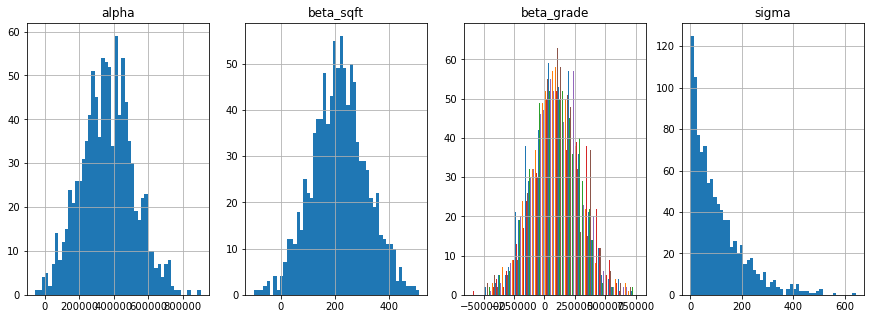

,mean,sd,hdi_3%,hdi_97%
alpha,360879.36,151958.76,59598.70,624398.00
beta_sqft,216.91,101.43,39.75,419.47
beta_grade[0],96549.79,199589.60,-254705.00,476141.00
beta_grade[1],98918.53,199478.78,-334956.00,417825.00
beta_grade[2],85498.75,199133.44,-286491.00,440735.00
beta_grade[3],111578.13,199931.50,-263238.00,480191.00
beta_grade[4],91907.74,196673.96,-274963.00,454903.00
beta_grade[5],95484.07,199936.23,-288437.00,455202.00
sigma,105.33,100.78,0.01,292.39


In [231]:
alpha_sim = two_params_discrete_ppc_simulated.stan_variable('alpha')
beta_grade_sim = two_params_discrete_ppc_simulated.stan_variable('beta_grade')
beta_sqft_sim = two_params_discrete_ppc_simulated.stan_variable('beta_sqft')
sigma_sim = two_params_discrete_ppc_simulated.stan_variable('sigma')
price_sim = two_params_discrete_ppc_simulated.stan_variable('price')

fig, axs = plt.subplots(1,4)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim, bins=50)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sqft_sim, bins=50)
axs[1].grid()
axs[1].set_title('beta_sqft')
axs[2].hist(beta_grade_sim, bins=50)
axs[2].grid()
axs[2].set_title('beta_grade')
axs[3].hist(sigma_sim, bins=50)
axs[3].grid()
axs[3].set_title('sigma')
plt.show()

az.summary(two_params_discrete_ppc_simulated, var_names=['alpha','beta_sqft', 'beta_grade','sigma'],round_to=2,kind='stats')

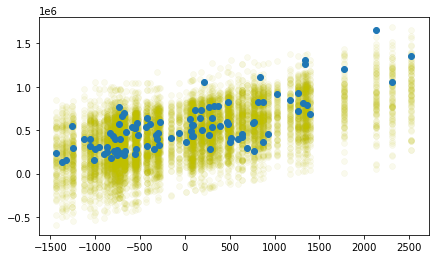

In [234]:
price_sim = two_params_discrete_ppc_simulated.stan_variable('price')


fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines(
    [price_standardized.min(),price_standardized.max()],
    xmin=sqft_living_standardized.min(),
    xmax=sqft_living_standardized.max(),
    linestyle='--', color='black'
    )
for i in range(100):
    plt.scatter(
        sqft_living_centered,
        price_sim[i],
        color = 'y', alpha=0.07, linewidth=0.5
        )

plt.scatter(sqft_living_centered, df['price'])

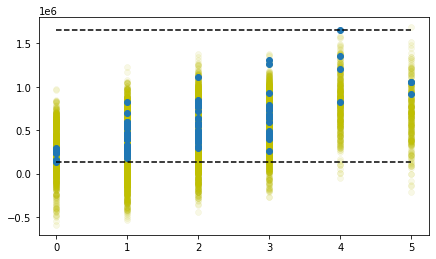

In [235]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines(
    [df['price'].min(),df['price'].max()],
    xmin=grade_moved.min(),
    xmax=grade_moved.max(),
    linestyle='--', color='black'
    )
for i in range(100):
    plt.scatter(
        grade_moved,
        price_sim[i],
        color = 'y', alpha=0.1, linewidth=0.5
        )

plt.scatter(grade_moved, df['price'])

### Posterior

In [236]:
data = {'N': len(sqft_living_standardized),
        'sqft': sqft_living_standardized,
        'grade': grade_moved,
        'price': df['price']}
two_params_discrete = CmdStanModel(stan_file='CommandFiles/two_param_discrete.stan')
two_params_simulated_discrete = two_params_discrete.sample(data=data, seed=21370204)

INFO:cmdstanpy:compiling stan file C:\STUFF\8th_semester\DA_project\CommandFiles\two_param_discrete.stan to exe file C:\STUFF\8th_semester\DA_project\CommandFiles\two_param_discrete.exe
INFO:cmdstanpy:compiled model executable: C:\STUFF\8th_semester\DA_project\CommandFiles\two_param_discrete.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/STUFF/8th_semester/DA_project/CommandFiles/two_param_discrete.hpp C:/STUFF/8th_semester/DA_project/CommandFiles/two_param_discrete.stan
Warning in 'C:/STUFF/8th_semester/DA_project/CommandFiles/two_param_discrete.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/STUFF/8th_semester/DA_project/CommandFiles/two_param_discrete.stan', line 33, column 3: Declaration
    of arrays by placing brackets afte


INFO:cmdstanpy:CmdStan done processing.


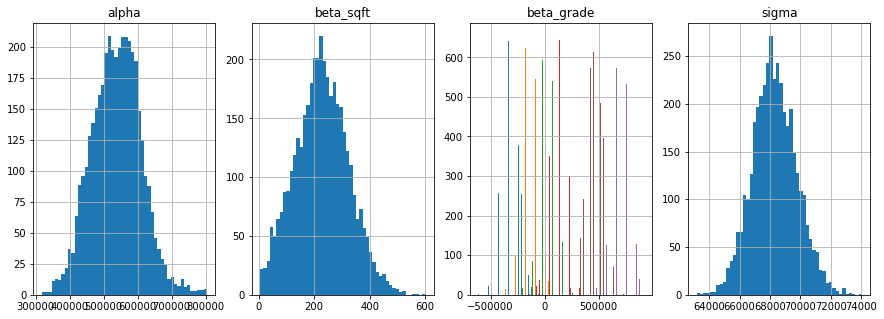

,mean,sd,hdi_3%,hdi_97%
alpha,537636.25,72552.87,399396.00,665843.00
beta_sqft,226.79,95.73,45.68,401.08
beta_grade[0],-310412.05,75643.51,-434713.00,-163181.00
beta_grade[1],-128956.91,73505.95,-260703.00,9460.03
beta_grade[2],29162.89,73335.57,-95840.40,173995.00
beta_grade[3],129232.49,73663.70,5174.84,272568.00
beta_grade[4],699536.23,77471.92,567461.00,849675.00
beta_grade[5],457532.77,79786.42,315604.00,613312.00
sigma,68296.25,1453.25,65479.40,70954.90


In [237]:
alpha_sim = two_params_simulated_discrete.stan_variable('alpha')
beta_grade_sim = two_params_simulated_discrete.stan_variable('beta_grade')
beta_sqft_sim = two_params_simulated_discrete.stan_variable('beta_sqft')
sigma_sim = two_params_simulated_discrete.stan_variable('sigma')
price_sim = two_params_simulated_discrete.stan_variable('prices')

fig, axs = plt.subplots(1,4)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim, bins=50)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sqft_sim, bins=50)
axs[1].grid()
axs[1].set_title('beta_sqft')
axs[2].hist(beta_grade_sim, bins=50)
axs[2].grid()
axs[2].set_title('beta_grade')
axs[3].hist(sigma_sim, bins=50)
axs[3].grid()
axs[3].set_title('sigma')
plt.show()

az.summary(two_params_simulated_discrete, var_names=['alpha','beta_sqft', 'beta_grade','sigma'],round_to=2,kind='stats')

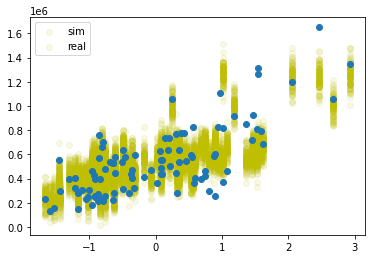

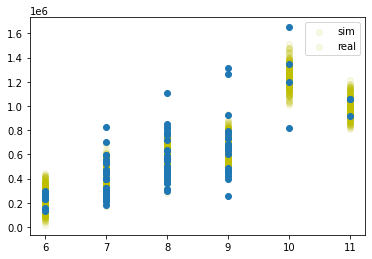

In [238]:
price_sim = two_params_simulated_discrete.stan_variable('prices')


for i in range(100):
    plt.scatter(sqft_living_standardized, price_sim[i], color="y", alpha=0.1)

plt.scatter(sqft_living_standardized,df['price'])
plt.legend(["sim", "real"])
plt.show()

for i in range(100):
    plt.scatter(grade_standardized, price_sim[i], color="y", alpha=0.1)
plt.scatter(grade_standardized,df['price'])
plt.legend(["sim", "real"])

## Comparison of models

In [239]:
idata1 = az.from_cmdstanpy(posterior = one_param_simulated, log_likelihood = "log_lik");
idata2 = az.from_cmdstanpy(posterior=two_params_simulated_discrete, log_likelihood="log_lik") ;
compare_dict = {"one_param_model": idata1, "two_param_discrete": idata2};

out_loo = az.compare(compare_dict, ic = "loo");
out_waic = az.compare(compare_dict, ic = "waic"); # loo stands for leave one out cross validation

c:\miniconda3\envs\cmdstan\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\miniconda3\envs\cmdstan\lib\site-packages\arviz\stats\stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
c:\miniconda3\envs\cmdstan\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\miniconda3\envs\cmdstan\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from p

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
two_param_discrete,0,-1630.062447,59.963239,0.000000,0.87221,80.306965,0.000000,True,log
one_param_model,1,-1951.922338,478.229619,321.859891,0.12779,63.157213,68.649899,True,log


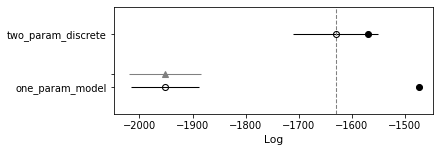

In [240]:
az.plot_compare(out_loo)
out_loo

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
two_param_discrete,0,-1630.091169,59.991961,0.000000,0.771616,80.352693,0.000000,True,log
one_param_model,1,-1687.700465,214.007745,57.609295,0.228384,44.967792,67.101629,True,log


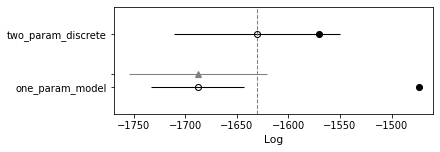

In [241]:
az.plot_compare(out_waic)
out_waic


1. The warnings are most likey caused by the outliers in the data: https://discourse.mc-stan.org/t/number-of-points-with-pareto-k-0-7-increases-when-a-subset-of-the-data-set-is-used/91081.